In [1]:
import os
from PIL import Image
import numpy as np
from itertools import combinations, product
from functools import lru_cache
from operator import itemgetter, attrgetter
from abc import ABC, abstractmethod
from collections import defaultdict
import re

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
images_folder = 'dev_dataset'

class MyImage:
    def __init__(self, img_name):
        path = os.path.join(images_folder, img_name)
        img = Image.open(path)
        
        self.img = np.array(img)
        self.name = img_name
        self.number = int(re.findall(r'\d+', img_name)[0])
        
        self.describe = lru_cache(maxsize=None)(self.describe)
    
    def __str__(self): 
        return f'img_{self.name}'
    
    def __repr__(self):
        return str(self)
    
    def describe(self, descriptor_class):
        return descriptor_class(self)
    
    def show(self):
        plt.figure(figsize = (10,10))
        plt.imshow(self.img)
    

images_names = os.listdir(images_folder)
images = list(map(MyImage, images_names))

images_by_name = {
    img.name: img
    for img in images
}

images_by_number = defaultdict(list)
for img in images:
    num = img.number
    images_by_number[num].append(img)

In [4]:
class Descriptor(ABC):
    def __init__(self, img):
        pass
    
    @abstractmethod
    def similar(self, other):
        pass
    
    @abstractmethod
    def visualize(self):
        pass

In [5]:
def interclass_measure(descriptor_class):
    res = defaultdict(list)
    
    for im1, im2 in product(images, repeat=2):
        d1 = im1.describe(descriptor_class)
        d2 = im2.describe(descriptor_class)
        
        measure = d1.similar(d2)
        
        if im1 == im2:
            res['same_image'].append(measure)
        elif im1.number == im2.number:
            res['same_class'].append(measure)
        else:
            res['different'].append(measure)
    
    for key, val in res.items():
        print(f'{key}\t{np.min(val):.3f}\t{np.mean(val):.3f}\t{np.max(val):.3f}')
        

def similarity(descriptor_class, img1, img2):
    d1 = img1.describe(descriptor_class)
    d2 = img2.describe(descriptor_class)
    return d1.similar(d2)
        
def distances_between_pairs(descriptor_class):
    measures = {}
    
    for img1, img2 in combinations(images, r=2):
        measure = similarity(descriptor_class, img1, img2)
        measures[f'{name1} and {name2}'] = measure
        
        return measures

In [6]:
def get_different_class_pairs_with_similarity_condition(descriptor_class, condition):
    res = []
    for im1, im2 in combinations(images, r=2):
        if im1.number == im2.number:
            continue
            
        measure = similarity(descriptor_class, im1, im2)

        if condition(measure):
            res.append((im1, im2))
            
    return res

# #1: similar histograms

In [7]:
class HistogramDescriptor(Descriptor):
    def __init__(self, img):
        self.img = img
        self.hist = np.histogram(img.img, bins=np.arange(256), density=True)[0]
        
    def similar(self, other):
        return np.linalg.norm(self.hist - other.hist, ord=1)

    def visualize(self):
        print(self.img.name)
        x = np.arange(256)
        y = self.hist
        iplot([Scatter(x=x, y=y)])

In [8]:
interclass_measure(HistogramDescriptor)

same_image	0.000	0.000	0.000
different	0.367	0.896	1.606
same_class	0.000	0.099	0.219


it already can distinguish all images in our dev dataset

### change l1 norm to pearson corrcoeff

In [9]:
class HistogramDescriptorPearson(HistogramDescriptor):
    def similar(self, other):
        return np.corrcoef(self.hist, other.hist)[0][1]

In [10]:
interclass_measure(HistogramDescriptorPearson)

same_image	1.000	1.000	1.000
different	-0.598	0.135	0.946
same_class	0.889	0.958	1.000


In [11]:
class HistogramDescriptorSpearman(HistogramDescriptor):
    def similar(self, other):
        from scipy.stats import spearmanr
        return spearmanr(self.hist, other.hist)[0]

In [12]:
interclass_measure(HistogramDescriptorSpearman)

same_image	1.000	1.000	1.000
different	-0.870	0.144	0.956
same_class	0.900	0.972	1.000


In [13]:
class HistogramDescriptorCustom(HistogramDescriptor):
    def similar(self, other):
        d1 = np.diff(self.hist) < 0
        d2 = np.diff(other.hist) < 0
        return np.sum(d1 ^ d2)

In [14]:
interclass_measure(HistogramDescriptorCustom)

same_image	0.000	0.000	0.000
different	77.000	123.262	154.000
same_class	0.000	48.429	86.000


# Let's add some color!

In [15]:
class ColorHistogramDescriptor(Descriptor):
    def __init__(self, img):
        self.img = img
        
        descriptor = np.zeros(shape=(3, 255), dtype=np.float)
        
        for i in range(3):
            channel = img.img[:, :, i]
            channel_descriptor = np.histogram(channel, bins=np.arange(256), density=True)[0]
            descriptor[i] = channel_descriptor
            
        self.hist = descriptor
        
    def similar(self, other):
        return sum(
            np.linalg.norm(self.hist[i] - other.hist[i], ord=1)
            for i in range(3)
        )
    
    def visualize(self):
        print(self.img.name)
        x = np.arange(256)
        y = self.hist
        iplot([Scatter(x=np.arange(256), y=self.hist[i])
              for i in range(3)])

In [16]:
interclass_measure(ColorHistogramDescriptor)

same_image	0.000	0.000	0.000
different	1.534	3.047	5.032
same_class	0.000	0.383	0.818


In [17]:
for im1, im2 in combinations(images, r=2):
    if similarity(ColorHistogramDescriptor, im1, im2) < 1:
        print(f'{im1.name}, {im2.name}')

11_duplicate.jpg, 11.jpg
11_duplicate.jpg, 11_modification.jpg
6_similar.jpg, 6.jpg
15.jpg, 15_modification.jpg
11.jpg, 11_modification.jpg
4.jpg, 4_similar.jpg
1.jpg, 1_duplicate.jpg


# kind of better.

# fft

In [18]:
def imshow(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')

In [19]:
def fft_image(img):
    img = img.img.copy()
    gray = np.mean(img, axis=2)
    transformed = np.fft.fft2(gray)
    transformed_amplitudes = np.log1p(np.real(transformed) ** 2 + np.imag(transformed) ** 2)
    return transformed_amplitudes

In [20]:
im1 = images_by_name['11_duplicate.jpg']
im2 = images_by_name['11_modification.jpg']
f1 = fft_image(im1)
f2 = fft_image(im2)

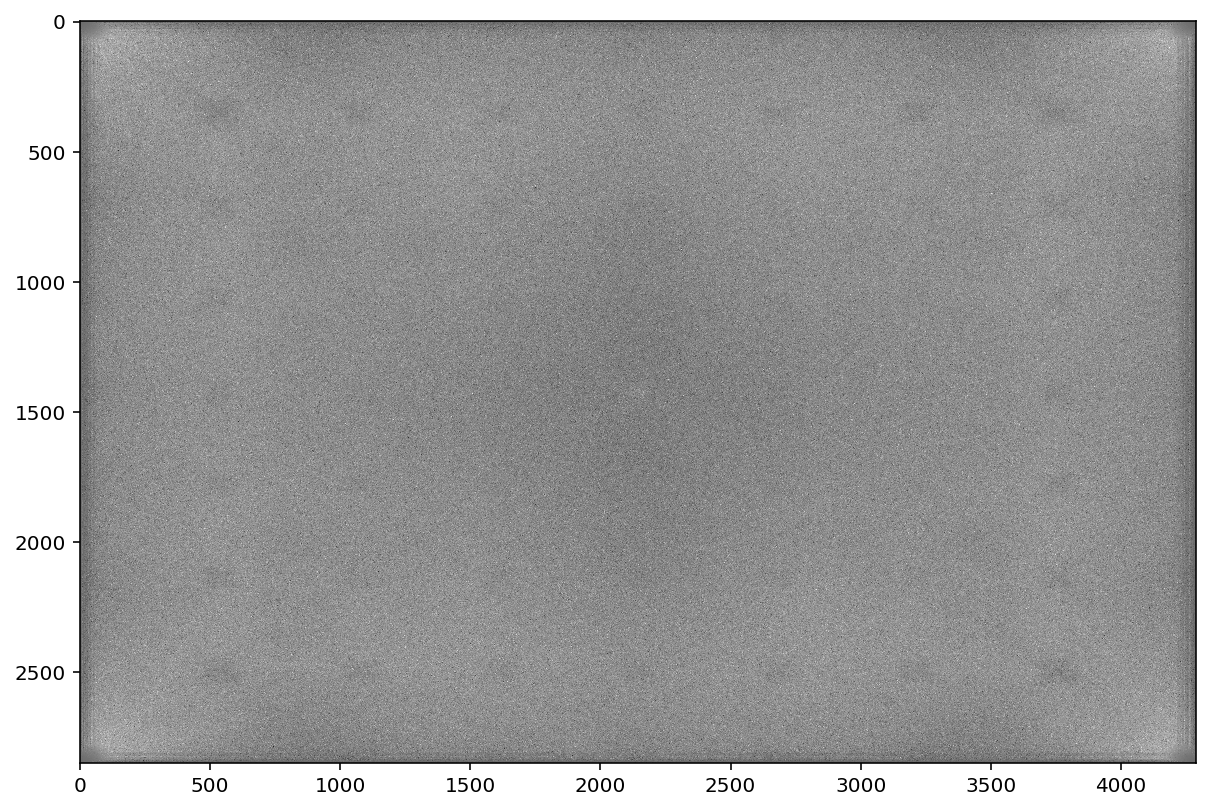

In [21]:
imshow(f1 - f2)

# introduction to computer vision

In [22]:
def conv2d(a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)


def gaussian_kernel(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)


def gaussian_smooth(img, kernel_size):
    sig = kernel_size / 3.0
    f = gaussian_kernel(kernel_size, sig)
    conved = conv2d(img, f)
    return conved

In [47]:
def to_grayscale(img):
    return np.mean(img, axis=2)

In [49]:
def get_edges(gray):
    x = np.diff(gray, axis=0)[:, :-1]
    y = np.diff(gray, axis=1)[:-1, :]
    return np.sqrt(x ** 2 + y ** 2)

# harris-stephens corners

In [26]:
def crop(img, dy, dx):
    def get_slice(x):
        if x > 0:  return slice(x, None, 1)
        if x == 0: return slice(0, None, 1)
        return slice(0, x, 1)
    
    return img[get_slice(dy), get_slice(dx)]

In [46]:
def harris_corner_error(img, delta = 1):
    res_shape = np.subtract(img.shape, (delta, delta))
    res = np.zeros(res_shape, dtype=np.float32)
    res = np.inf
    for dx, dy in product([-delta, delta], repeat=2):
        diffs = np.abs(crop(img, dx, dy) - crop(img, -dx, -dy))
        res = np.minimum(res, diffs)

    kernel_size = 10
    res = gaussian_smooth(res, kernel_size)
    
    return res

In [29]:
def random_tuples(y, x, n):
    out = np.ndarray(shape=(n, 2), dtype=np.int32)
    out[:, 0] = np.random.randint(0, y, n)
    out[:, 1] = np.random.randint(0, x, n)
    return out

In [30]:
def slice_around_point(point, kernel_size):
    half = kernel_size // 2
    return slice(point - half, point + half + 1, None)

In [72]:
def resize_img(img, *shape):
    img = Image.fromarray(img).resize(shape)
    return np.array(img)

harris_corners_shape = (500, 500)

def get_interest_points(img):
    if img.shape != harris_corners_shape:
        img = resize_img(img, *harris_corners_shape)
        
    threshold = np.mean(img) + np.std(img) * 2.5
    interest_points = []
    
    for y, x in random_tuples(*img.shape, sum(img.shape)):
        if img[y, x] <= threshold:
            continue

        interest_point = img[
            slice_around_point(y, kernel_size), 
            slice_around_point(x, kernel_size)
        ]
        rel_y = y / img.shape[0]
        rel_x = x / img.shape[1]
        interest_points.append((interest_point, rel_y, rel_x))

    return interest_points

In [73]:
def place_at(y, x, h, w):
    return slice(y, y+h), slice(x, x+w)

def kinda_hough_transform(img, interest_points):
    if img.shape != harris_corners_shape:
        img = resize_img(img, *harris_corners_shape)

    out_shape = np.array(harris_corners_shape) * 2
    halfheight, halfwidth = out_shape // 2
    center = np.array([0.5, 0.5])

    out = np.zeros(shape=out_shape, dtype=np.float32)
    for interest_point, rel_y, rel_x in interest_points:
        point_rel = np.array([rel_y, rel_x]) * 0.5
        shift = np.int32((center - point_rel) * out_shape)
        conved = conv2d(img, interest_point)
        out[place_at(*shift, *conved.shape)] += conved
        
    return np.max(out)

In [74]:
def get_edges_from_image(img):
    gray = to_grayscale(img)
    edges = get_edges(gray)
    return edges

In [75]:
img = images[0].img.copy()
edges = get_edges_from_image(img)
interest_points = get_interest_points(edges)
kinda_hough_transform(edges, interest_points)

3237660.0

In [79]:
class InterestPointDescriptor(Descriptor):
    def __init__(self, img):
        self.img = img
                
        edges = get_edges_from_image(img.img)
        
        self.tiny_img = resize_img(edges, *harris_corners_shape)
        self.descriptor = get_interest_points(self.tiny_img)
        
    def similar(self, other):
        return kinda_hough_transform(other.tiny_img, interest_points)
    
    def visualize(self):
        pass

### oh, even if it does work, it's already been a while.

In [80]:
interclass_measure(InterestPointDescriptor)

same_image	169488.281	1300659.875	3237660.000
different	169488.281	1312026.625	3237660.000
same_class	169488.281	1034348.188	1908309.125
